In [16]:
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

# Import all our models
import xgboost as xgb
import tensorflow as tf
from sklearn.linear_model import LinearRegression # Our fusion model
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print("--- Starting Model Fusion Pipeline ---")

--- Starting Model Fusion Pipeline ---


In [24]:
# --- Model & Data Files ---
# This is the final XGBoost model with lag features
XGB_MODEL_FILE = 'xgboost_model_final.joblib' 
# These are the files from the 1-step LSTM script
LSTM_MODEL_FILE = 'lstm_model_1step.keras'
X_SCALER_FILE = 'lstm_x_scaler_1step.joblib'
Y_SCALER_FILE = 'lstm_y_scaler_1step.joblib'

# Output files
FUSION_MODEL_FILE = 'fusion_model.joblib'
CHART_FILE = 'fusion_model_prediction.png'

# Source data
CLEANED_DATA_FILE = 'data/cleaned_bangalore_data.csv'

# --- Configuration (MUST MATCH OTHER SCRIPTS) ---
TARGET_COLUMN = 'Phase3_power'
SPLIT_DATE = '2021-05-20'
N_LOOKBACK = 72 # From LSTM

In [18]:
# --- Step 1: Prepare Data (XGBoost Features) ---
print("Preparing data for XGBoost (2D tabular)...")
# This function must be identical to the one in train_xgboost.py
def create_features_xgb(df, target_col):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    # Add lag and rolling features
    df[f'{target_col}_lag_1h'] = df[target_col].shift(1)
    df[f'{target_col}_lag_3h'] = df[target_col].shift(3)
    df[f'{target_col}_lag_24h'] = df[target_col].shift(24)
    df[f'{target_col}_roll_avg_3h'] = df[target_col].rolling(window=3).mean().shift(1)
    df[f'{target_col}_roll_avg_6h'] = df[target_col].rolling(window=6).mean().shift(1)
    df[f'{target_col}_roll_avg_24h'] = df[target_col].rolling(window=24).mean().shift(1)
    return df

# Load and process data
df = pd.read_csv(CLEANED_DATA_FILE, index_col='_time', parse_dates=True)
df_xgb = create_features_xgb(df, target_col=TARGET_COLUMN)
# Drop NaNs created by lag/rolling features
df_xgb.dropna(inplace=True) 

Preparing data for XGBoost (2D tabular)...


In [19]:
# --- Step 2: Prepare Data (LSTM Features) ---
print("Preparing data for LSTM (3D sequential)...")
FEATURES_LSTM = [
    'Phase2_current', 'Phase2_voltage', 'Phase3_frequency', 
    'Phase3_pf', 'Phase3_power', 'Phase3_voltage'
]
df_lstm = df[FEATURES_LSTM].loc[df_xgb.index] # Align with df_xgb
df_y = df[[TARGET_COLUMN]].loc[df_xgb.index] # Align with df_xgb

# Load scalers
X_scaler = joblib.load(X_SCALER_FILE)
y_scaler = joblib.load(Y_SCALER_FILE)

# Scale data
X_scaled = X_scaler.transform(df_lstm)

# Create sequences
def create_sequences_lstm(x_data, n_lookback):
    X = []
    # Start loop so that the *end* of the loop aligns with the end of the data
    for i in range(len(x_data) - n_lookback + 1):
        X.append(x_data[i : (i + n_lookback)])
    return np.array(X)

X_seq = create_sequences_lstm(X_scaled, N_LOOKBACK)
print(f"LSTM sequences created. Shape: {X_seq.shape}")

Preparing data for LSTM (3D sequential)...
LSTM sequences created. Shape: (3093, 72, 6)


In [20]:
# --- Step 3: Align Test Sets ---
# This is the most important step! We must get predictions for the *exact same* timestamps.
print(f"Aligning test sets... Splitting at {SPLIT_DATE}")

# We need to find the common index (post-NaNs)
common_index = df_xgb.index 
#
# --- THIS IS THE FIX ---
# We must make our SPLIT_DATE "timezone-aware" by setting it to UTC
#
split_date_aware = pd.to_datetime(SPLIT_DATE, utc=True)
common_index_start = max(df_xgb.index[0], df_lstm.index[N_LOOKBACK-1])
common_index_start = max(common_index_start, split_date_aware)
#
# --- END OF FIX ---
#

test_index = df_xgb.loc[df_xgb.index >= common_index_start].index
print(f"Aligned test set starts at: {test_index[0]}")

# 1. Get XGBoost Test Set (X_test_xgb)
FEATURES_XGB = [
    'Phase2_current', 'Phase2_voltage', 'Phase3_frequency', 'Phase3_pf', 'Phase3_voltage',
    'hour', 'dayofweek', 'month', 'quarter', 'year', 'dayofyear',
    f'{TARGET_COLUMN}_lag_1h', f'{TARGET_COLUMN}_lag_3h', f'{TARGET_COLUMN}_lag_24h',
    f'{TARGET_COLUMN}_roll_avg_3h', f'{TARGET_COLUMN}_roll_avg_6h', f'{TARGET_COLUMN}_roll_avg_24h',
]
X_test_xgb = df_xgb.loc[test_index][FEATURES_XGB]

# 2. Get LSTM Test Set (X_test_lstm)
# This is tricky. We must find the starting row index
start_row_idx = df.index.get_loc(test_index[0])
X_test_lstm = X_seq[start_row_idx - (N_LOOKBACK - 1) : ]

# 3. Get True Target (y_test)
y_test = df_xgb.loc[test_index][TARGET_COLUMN]

# Adjust lengths to be identical
min_len = min(len(X_test_xgb), len(X_test_lstm), len(y_test))
X_test_xgb = X_test_xgb.iloc[:min_len]
X_test_lstm = X_test_lstm[:min_len]
y_test = y_test.iloc[:min_len]

print(f"Final aligned test set length: {min_len}")

Aligning test sets... Splitting at 2021-05-20
Aligned test set starts at: 2021-05-20 00:00:00+00:00
Final aligned test set length: 2123


In [26]:
# --- Step 4: Get Base Model Predictions ---
print("Loading base models and generating predictions...")

# Load XGBoost model
model_xgb = joblib.load(XGB_MODEL_FILE)
pred_xgb = model_xgb.predict(X_test_xgb)

# Load LSTM model
model_lstm = tf.keras.models.load_model(LSTM_MODEL_FILE)
pred_lstm_scaled = model_lstm.predict(X_test_lstm)
pred_lstm = y_scaler.inverse_transform(pred_lstm_scaled).flatten() # Flatten to 1D

Loading base models and generating predictions...
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


In [27]:
# --- Step 5: Train the Fusion Model (Stacking) ---
print("Training the fusion model...")

# Create the "meta-dataset"
X_meta = pd.DataFrame({
    'xgb_pred': pred_xgb,
    'lstm_pred': pred_lstm
})
y_meta = y_test

# Train the simple fusion model (Linear Regression)
fusion_model = LinearRegression()
fusion_model.fit(X_meta, y_meta)

print("Fusion model trained.")
# Print the learned "weights" for each model
print(f"Fusion weights: XGB_weight={fusion_model.coef_[0]:.4f}, LSTM_weight={fusion_model.coef_[1]:.4f}")

Training the fusion model...
Fusion model trained.
Fusion weights: XGB_weight=0.9784, LSTM_weight=0.0937


In [28]:
# --- Step 6: Evaluate All Models ---
print("\n--- Final Model Evaluation ---")

# Get fusion predictions
pred_fusion = fusion_model.predict(X_meta)

# Calculate MAPEs
mape_xgb = mean_absolute_percentage_error(y_test, pred_xgb)
mape_lstm = mean_absolute_percentage_error(y_test, pred_lstm)
mape_fusion = mean_absolute_percentage_error(y_test, pred_fusion)

print(f"XGBoost Model (Base) MAPE:   {mape_xgb * 100:.4f} %")
print(f"LSTM Model (Base) MAPE:      {mape_lstm * 100:.4f} %")
print(f"FUSION Model (Hybrid) MAPE:  {mape_fusion * 100:.4f} %")

if mape_fusion < mape_xgb and mape_fusion < mape_lstm:
    print("\nSUCCESS: The Hybrid Fusion model is more accurate than either base model!")
else:
    print("\nNote: The Fusion model did not improve accuracy. This indicates one of the base models is not adding value.")


--- Final Model Evaluation ---
XGBoost Model (Base) MAPE:   40.5542 %
LSTM Model (Base) MAPE:      49.3340 %
FUSION Model (Hybrid) MAPE:  30.3778 %

SUCCESS: The Hybrid Fusion model is more accurate than either base model!


Saving fusion model to fusion_model.joblib...
Generating plot... saving to fusion_model_prediction.png
--- Fusion Pipeline Complete ---


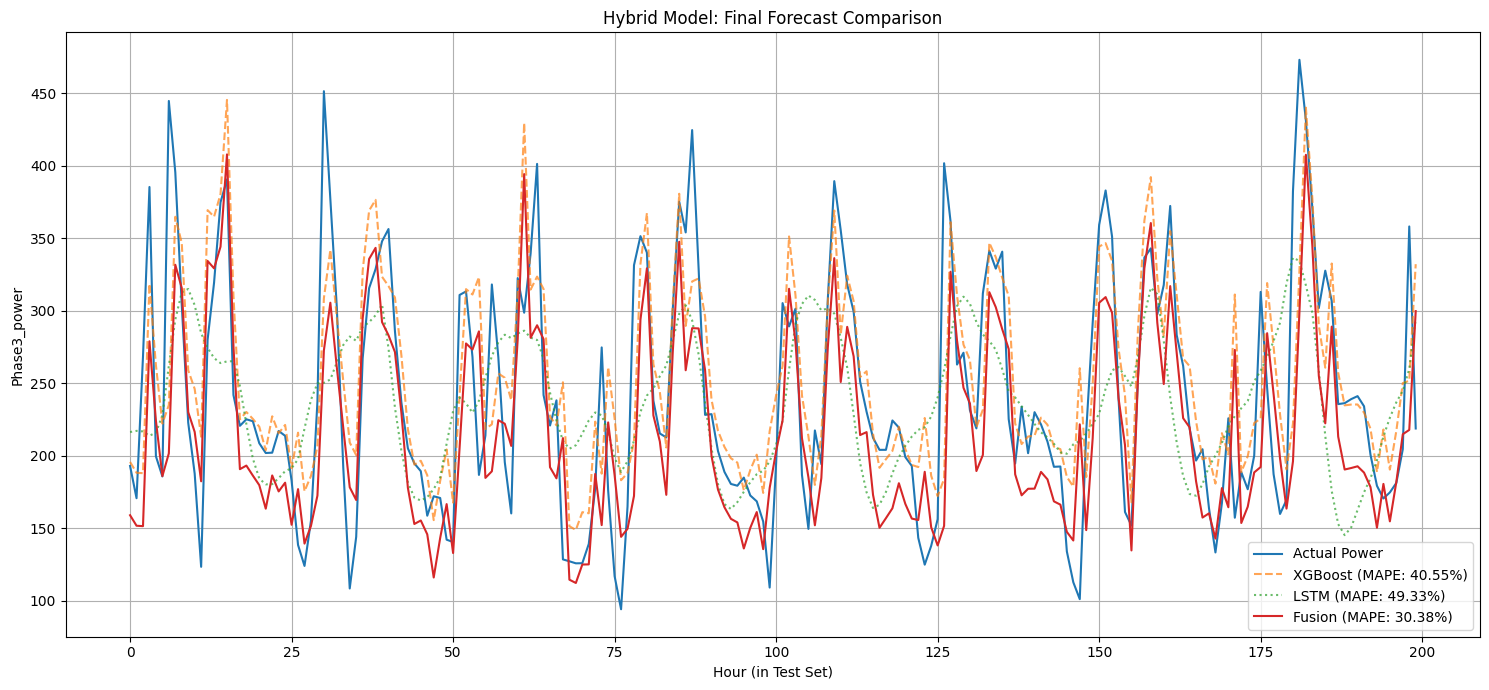

In [29]:
# --- Step 7: Save Fusion Model & Visualize ---
print(f"Saving fusion model to {FUSION_MODEL_FILE}...")
joblib.dump(fusion_model, FUSION_MODEL_FILE)

print(f"Generating plot... saving to {CHART_FILE}")
plt.figure(figsize=(15, 7))
# Plot the first 200 data points of the test set
plt.plot(y_test.values[:200], label='Actual Power')
plt.plot(pred_xgb[:200], label=f'XGBoost (MAPE: {mape_xgb*100:.2f}%)', alpha=0.7, linestyle='--')
plt.plot(pred_lstm[:200], label=f'LSTM (MAPE: {mape_lstm*100:.2f}%)', alpha=0.7, linestyle=':')
plt.plot(pred_fusion[:200], label=f'Fusion (MAPE: {mape_fusion*100:.2f}%)', alpha=1.0, linestyle='-')
plt.title('Hybrid Model: Final Forecast Comparison')
plt.xlabel('Hour (in Test Set)')
plt.ylabel(TARGET_COLUMN)
plt.legend()
plt.grid(True)
plt.tight_layout()
# --- THIS IS THE TYPO FIX ---
plt.savefig(CHART_FILE)

print("--- Fusion Pipeline Complete ---")